<div dir="rtl" style="text-align: justify;">
    <h1>پیش‌بینی ارزش سهام به کمک شبکه‌ عصبی بازگشتی با PyTorch</h1>
     یکی از کارهایی که RNNها قادر به انجام‌دادن آن هستند پیش‌بینی سری‌های زمانی است. در این قسمت ما قصد داریم قیمت‌های آینده سهام شرکت اپل (AAPL) را با استفاده از داده‌های تاریخی پیش‌بینی کنیم.درواقع مدل با تحلیل الگوها و روندهای موجود در داده‌های تاریخی، سعی می‌کند قیمت‌ها لحظه بسته‌شدن سهام را برای روزهای آینده پیش‌بینی کند.  
</div>

In [2]:
# !pip install yfinance

In [53]:
import torch
import numpy as np
import pandas as pd
import yfinance as yf
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset


In [6]:
df = yf.download('AAPL', start='2010-01-01', end='2021-01-01')

[*********************100%***********************]  1 of 1 completed


In [9]:
df.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.454505,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.465664,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.362821,552160000


In [10]:
data = df['Close'].values.astype(float)
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data.reshape(-1, 1))

In [11]:
def create_sequences(data, seq_length):
    # Initialize a list to store input sequences
    xs = []
    # Initialize a list to store target values
    ys = []
    for i in range(len(data)-seq_length):
        # Extract a sequence of length seq_length
        x = data[i:i+seq_length]
        # Extract the next data point
        y = data[i+seq_length]
        # Append the sequence to the input list
        xs.append(x)
        # Append the target value to the target list
        ys.append(y)
    return np.array(xs), np.array(ys)

In [12]:
seq_length = 30
X, y = create_sequences(data_normalized, seq_length)

In [13]:
X.shape

(2739, 30, 1)

In [14]:
y.shape

(2739, 1)

In [61]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

# Define the RNN model

In [39]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Use only the last time step's output for prediction
        return out

In [40]:
X_train_tensor.shape

torch.Size([2191, 30, 1])

In [62]:
# Initialize model, loss function, and optimizer
input_size = 1  # Number of features in input (1 since we have only closing prices)
hidden_size = 50
output_size = 1  # Predicting one value (next closing price)
model = SimpleRNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [63]:
# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64  # Define your batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [73]:
batch_size = 64  # Define your batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the RNN model using nn.Sequential
class SimpleRNN(nn.Module):
    def __init__(self):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=50, batch_first=True)
        self.fc = nn.Linear(50, 1)  # Fully connected layer

    def forward(self, x):
        rnn_out, _ = self.rnn(x)  # Take only the output from the RNN
        last_time_step_output = rnn_out[:, -1, :]  # Get the last time step output
        out = self.fc(last_time_step_output)  # Pass through fully connected layer
        return out


In [113]:
model = SimpleRNN()
# Set up loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
train_losses = []
test_losses = []


In [114]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)  # Forward pass through the model
        loss = criterion(outputs, batch_y)  # Compute loss
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_train_loss  = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Test loss calculation (evaluation mode)
    model.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)  # Compute test loss
            epoch_test_loss += loss.item()

    avg_test_loss = epoch_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}')

        


Epoch [10/100], Train Loss: 0.000119, Test Loss: 0.002383
Epoch [20/100], Train Loss: 0.000098, Test Loss: 0.003226
Epoch [30/100], Train Loss: 0.000087, Test Loss: 0.003644
Epoch [40/100], Train Loss: 0.000095, Test Loss: 0.004488
Epoch [50/100], Train Loss: 0.000077, Test Loss: 0.004621
Epoch [60/100], Train Loss: 0.000081, Test Loss: 0.003917
Epoch [70/100], Train Loss: 0.000098, Test Loss: 0.003934
Epoch [80/100], Train Loss: 0.000085, Test Loss: 0.003273
Epoch [90/100], Train Loss: 0.000093, Test Loss: 0.002956
Epoch [100/100], Train Loss: 0.000075, Test Loss: 0.002709


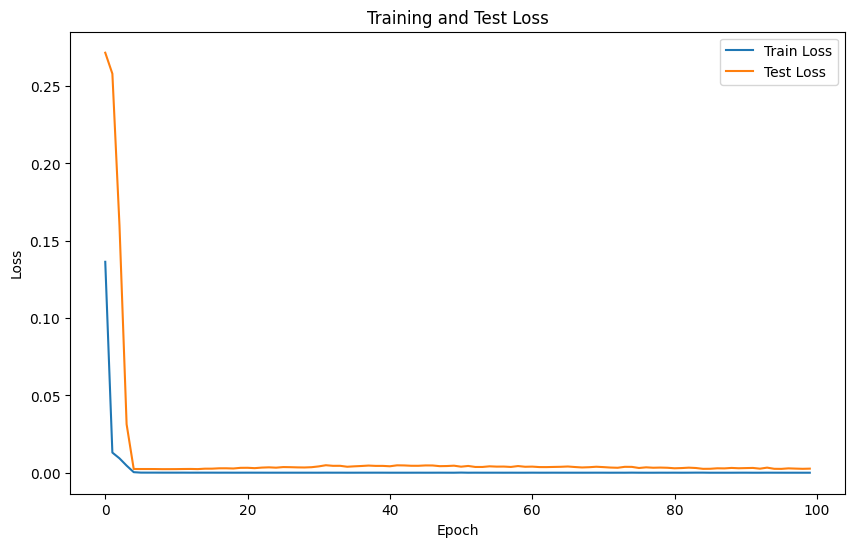

In [115]:

# Plot the training and test losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [116]:
# Set model to evaluation mode
model.eval()

# Make predictions on the train set
with torch.no_grad():
    train_predictions = model(X_train_tensor).squeeze()  # Get predictions for train set
    train_predictions = train_predictions.numpy()  # Convert to NumPy for plotting

# Make predictions on the test set
with torch.no_grad():
    test_predictions = model(X_test_tensor).squeeze()  # Get predictions for test set
    test_predictions = test_predictions.numpy()  # Convert to NumPy for plotting

# Inverse transform the predictions and actual values to original scale
train_predicted_prices = scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predicted_prices = scaler.inverse_transform(test_predictions.reshape(-1, 1))

train_actual_prices = scaler.inverse_transform(y_train_tensor.numpy().reshape(-1, 1))
test_actual_prices = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))

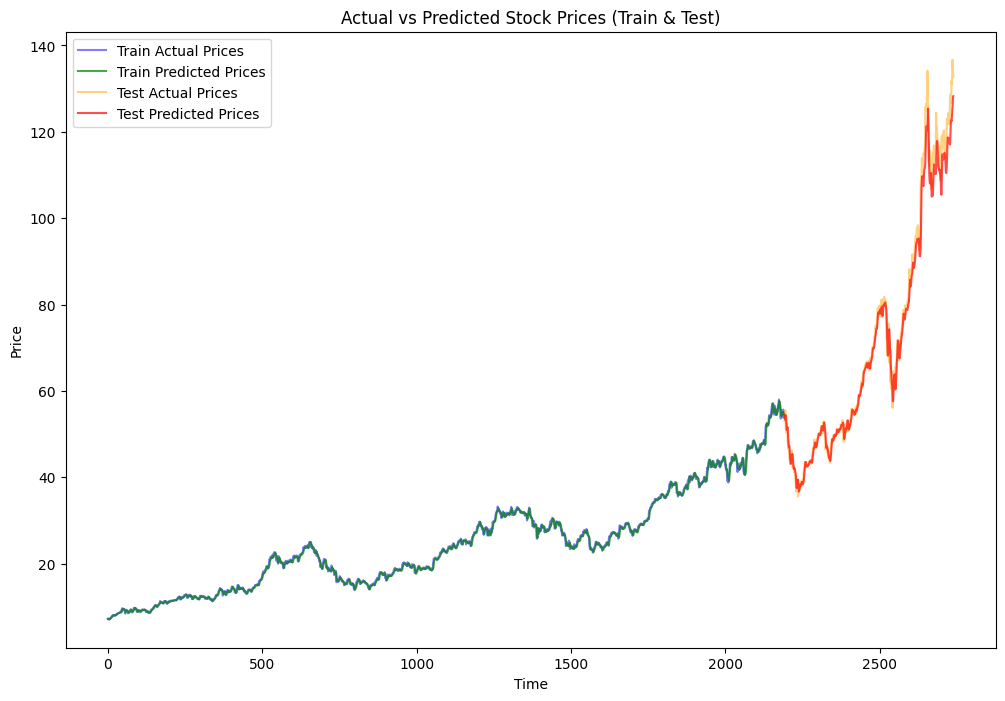

In [117]:

# Plot the actual prices vs predicted prices for both train and test sets
plt.figure(figsize=(12, 8))

# Plot train actual and predicted values
plt.plot(train_actual_prices, label='Train Actual Prices', color='blue', alpha=0.5)
plt.plot(train_predicted_prices, label='Train Predicted Prices', color='green', alpha=0.7)

# Plot test actual and predicted values
plt.plot(range(len(train_actual_prices), len(train_actual_prices) + len(test_actual_prices)),
         test_actual_prices, label='Test Actual Prices', color='orange', alpha=0.5)
plt.plot(range(len(train_actual_prices), len(train_actual_prices) + len(test_actual_prices)),
         test_predicted_prices, label='Test Predicted Prices', color='red', alpha=0.7)

plt.title('Actual vs Predicted Stock Prices (Train & Test)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [101]:
# LSTM Model Definition
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Use the last hidden state for prediction
        return out

In [108]:
# Parameters
input_size = 1
hidden_size = 64
num_layers = 2
output_size = 1
seq_length = 30
batch_size = 64
num_epochs = 100

# Create LSTM Model
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [109]:

# Training the LSTM Model
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    # Evaluate on the test set
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
    test_losses.append(test_loss / len(test_loader))

    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')



Epoch 10/100, Train Loss: 0.0002, Test Loss: 0.0770
Epoch 20/100, Train Loss: 0.0002, Test Loss: 0.0553
Epoch 30/100, Train Loss: 0.0002, Test Loss: 0.0404
Epoch 40/100, Train Loss: 0.0002, Test Loss: 0.0311
Epoch 50/100, Train Loss: 0.0001, Test Loss: 0.0250
Epoch 60/100, Train Loss: 0.0001, Test Loss: 0.0227
Epoch 70/100, Train Loss: 0.0002, Test Loss: 0.0189
Epoch 80/100, Train Loss: 0.0001, Test Loss: 0.0176
Epoch 90/100, Train Loss: 0.0001, Test Loss: 0.0168
Epoch 100/100, Train Loss: 0.0002, Test Loss: 0.0149


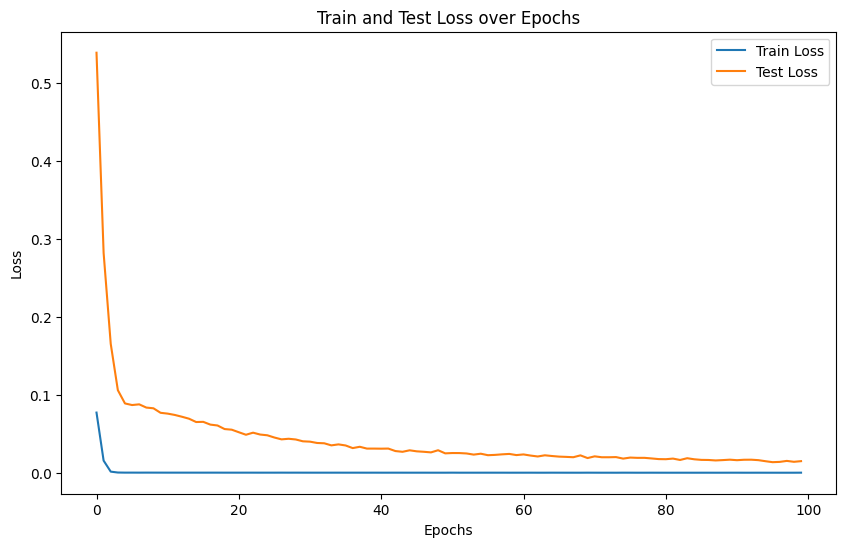

In [110]:
# Plot the Loss Curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Train and Test Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [111]:
# Generate Predictions and Plotting
model.eval()

with torch.no_grad():
    train_predictions = model(X_train_tensor).squeeze().numpy()
    test_predictions = model(X_test_tensor).squeeze().numpy()

train_predicted_prices = scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predicted_prices = scaler.inverse_transform(test_predictions.reshape(-1, 1))
train_actual_prices = scaler.inverse_transform(y_train_tensor.numpy().reshape(-1, 1))
test_actual_prices = scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))

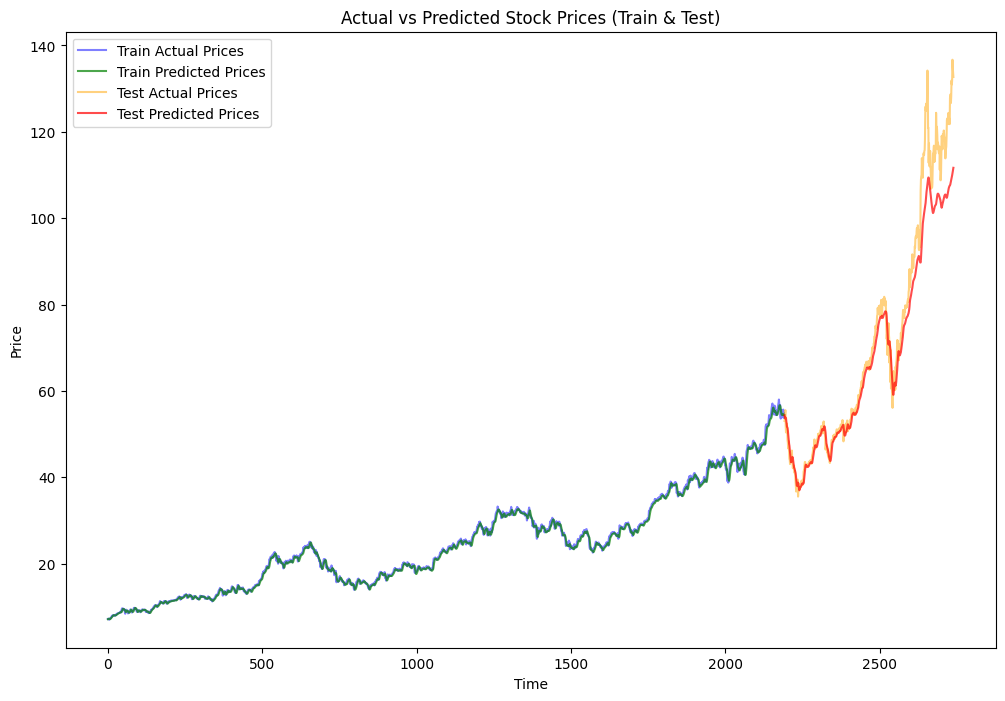

In [112]:
# Plotting the Actual vs Predicted Prices
plt.figure(figsize=(12, 8))
plt.plot(train_actual_prices, label='Train Actual Prices', color='blue', alpha=0.5)
plt.plot(train_predicted_prices, label='Train Predicted Prices', color='green', alpha=0.7)
plt.plot(range(len(train_actual_prices), len(train_actual_prices) + len(test_actual_prices)),
         test_actual_prices, label='Test Actual Prices', color='orange', alpha=0.5)
plt.plot(range(len(train_actual_prices), len(train_actual_prices) + len(test_actual_prices)),
         test_predicted_prices, label='Test Predicted Prices', color='red', alpha=0.7)

plt.title('Actual vs Predicted Stock Prices (Train & Test)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()